In [1]:
# Import Libraries

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

# XGBoost model library
import xgboost as xgb

### Import data

In [2]:
final_df = pd.read_csv('final_df_next_7th_day_15.csv').reset_index(drop=True)

In [3]:
def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    MSE = metrics.mean_squared_error(y, ypred,squared=True)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    R2 = metrics.r2_score(y, ypred)
    return MAE,MSE,RMSE,R2

def plot_result(df,title=None):
    plt.figure(figsize=(25, 6))
    plt.plot( df.iloc[:, 1], label='Actual')
    plt.plot( df.iloc[:, 2], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

### XGBoost

In [4]:
# Manually split and create train & test set
test_size = 0.2
num_rows = int(np.round(len(final_df) * test_size))

# Split final_df into separate DataFrames based on the number of rows
train_split = final_df[:len(final_df)-num_rows]
test_split = final_df[len(final_df)-num_rows:]

# Drop targets from datasets
x_train = train_split.drop(['next_7th_day_closing_price','Date'],axis=1).values
x_test = test_split.drop(['next_7th_day_closing_price','Date'],axis=1).values

# Assign target column to Y
y_train = train_split['next_7th_day_closing_price'].reset_index(drop=True).values
y_test = test_split['next_7th_day_closing_price'].reset_index(drop=True).values

# Set up the XGBoost model
xgbm_reg = xgb.XGBRegressor(n_estimators=300, max_depth=6, objective='reg:squarederror', learning_rate=0.01, n_jobs=-1)

# Train the model with early stopping
xgbm_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=10, verbose=False)

# Make predictions on the training and test sets
ytrain_pred_xgb = xgbm_reg.predict(x_train)
ytest_pred_xgb = xgbm_reg.predict(x_test)

In [5]:
MAE_train, MSE_train, RMSE_train, R2_train = calculate_metrics(y_train, ytrain_pred_xgb)
MAE_test, MSE_test, RMSE_test, R2_test = calculate_metrics(y_test, ytest_pred_xgb)

print("Mean Absolute Error (MAE) for Training:", MAE_train)
print("Mean Squared Error (MSE) for Training:", MSE_train)
print("Root Mean Squared Error (RMSE) for Training:", RMSE_train)
print("R-squared score (R2) for Training:", R2_train)
print("\n********************************************\n")
print("Mean Absolute Error (MAE) for Testing:", MAE_test)
print("Mean Squared Error (MSE) for Testing:", MSE_test)
print("Root Mean Squared Error (RMSE) for Testing:", RMSE_test)
print("R-squared score (R2) for Testing:", R2_test)

Mean Absolute Error (MAE) for Training: 181.27896920336258
Mean Squared Error (MSE) for Training: 174152.37585593516
Root Mean Squared Error (RMSE) for Training: 417.3156789002004
R-squared score (R2) for Training: 0.9881644133204537

********************************************

Mean Absolute Error (MAE) for Testing: 20760.666927153263
Mean Squared Error (MSE) for Testing: 630208783.1381836
Root Mean Squared Error (RMSE) for Testing: 25103.95951116444
R-squared score (R2) for Testing: -2.072331047581548


In [6]:
# Analyze & test parameters with GridSearchCV

from sklearn.model_selection import GridSearchCV

%%time

parameters = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [6, 10, 15],
    'gamma': [0.02, .1, .3],
    'random_state': [42]
}
clf = GridSearchCV(xgbm_reg, parameters)

clf.fit(x_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000, 'random_state': 42}
Best validation score = 0.09108037919822423
CPU times: total: 1h 48min 36s
Wall time: 7min 15s


In [7]:
# Test data for best early stopping round

xgbm_reg.best_ntree_limit

300

In [8]:
# Set up the XGBoost model with new parameters
xgbm_reg = xgb.XGBRegressor(gamma=0.3, learning_rate=0.05, max_depth=15, n_estimators=1000, random_state=42, n_jobs=-1, objective='reg:squarederror')

# Retrain the model
xgbm_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=300, verbose=False, eval_metric='rmse', 
             callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)])

# Make predictions on the training and test sets
ytrain_pred_xgb = xgbm_reg.predict(x_train)
ytest_pred_xgb = xgbm_reg.predict(x_test)

In [9]:
MAE_train,MSE_train,RMSE_train,R2_train = calculate_metrics(y_train,ytrain_pred_xgb)
MAE_test,MSE_test,RMSE_test,R2_test = calculate_metrics(y_test,ytest_pred_xgb)

print("Mean Absolute Error (MAE) for Training:", MAE_train)
print("Mean Squared Error (MSE) for Training:", MSE_train)
print("Root Mean Squared Error (RMSE) for Training:", RMSE_train)
print("R-squared score (R2) for Training:", R2_train)
print("********************************************")
print("Mean Absolute Error (MAE) for Testing:", MAE_test)
print("Mean Squared Error (MSE) for Testing:", MSE_test)
print("Root Mean Squared Error (RMSE) for Testing:", RMSE_test)
print("R-squared score (R2) for Testing:", R2_test)

Mean Absolute Error (MAE) for Training: 0.3920137820313088
Mean Squared Error (MSE) for Training: 0.49152792722664485
Root Mean Squared Error (RMSE) for Training: 0.7010905271265936
R-squared score (R2) for Training: 0.9999999665952224
********************************************
Mean Absolute Error (MAE) for Testing: 20130.221058715426
Mean Squared Error (MSE) for Testing: 602598573.9189291
Root Mean Squared Error (RMSE) for Testing: 24547.883287952325
R-squared score (R2) for Testing: -1.9377285074643975


In [10]:
xgb_result_test_df = pd.DataFrame()
xgb_result_test_df['Date'] = test_split['Date']
xgb_result_test_df['y_test'] = test_split['next_7th_day_closing_price']
xgb_result_test_df['y_test_pred'] = ytest_pred_xgb.flatten()


xgb_result_train_df = pd.DataFrame()
xgb_result_train_df['Date'] = train_split['Date']
xgb_result_train_df['y_train'] = train_split['next_7th_day_closing_price']
xgb_result_train_df['y_train_pred'] = ytrain_pred_xgb.flatten()

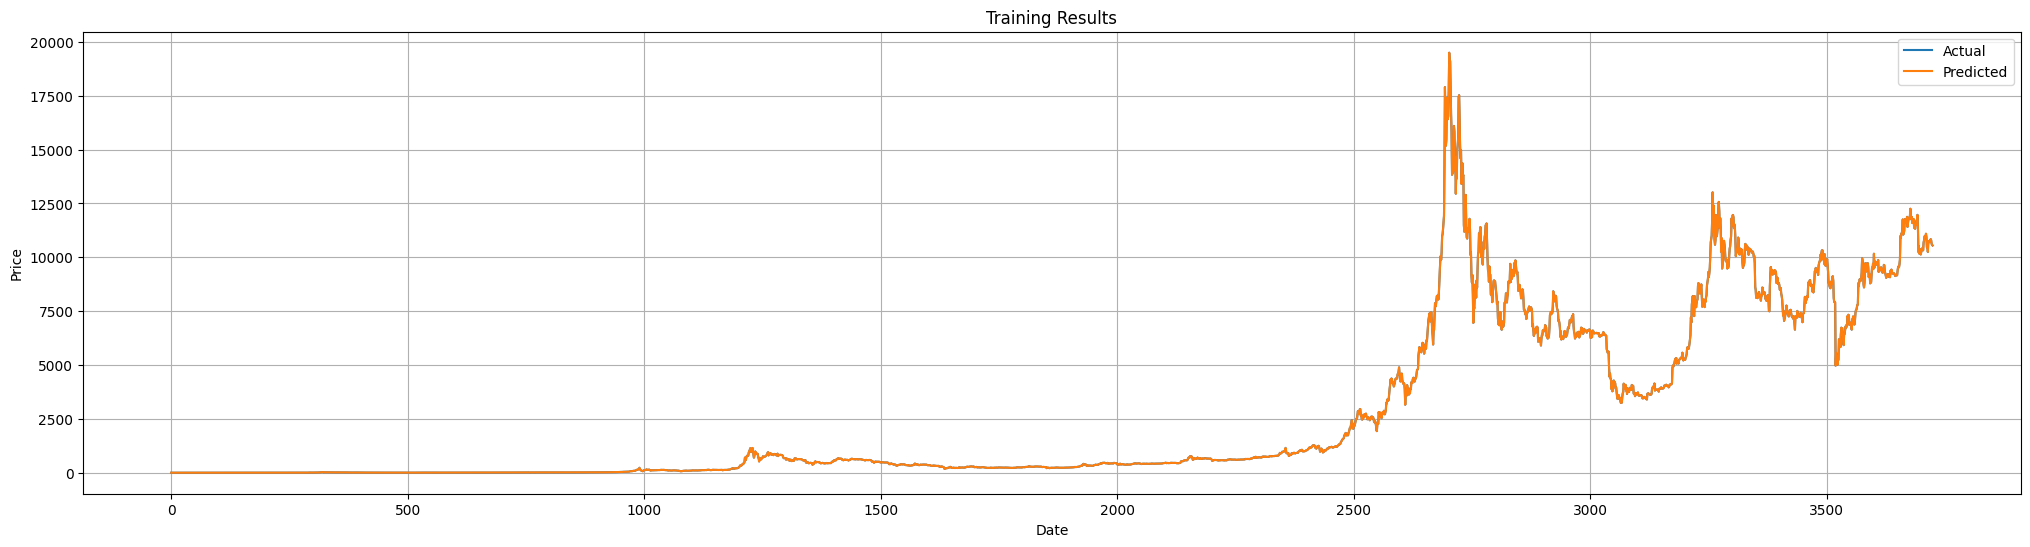

In [11]:
plot_result(xgb_result_train_df,'Training Results')

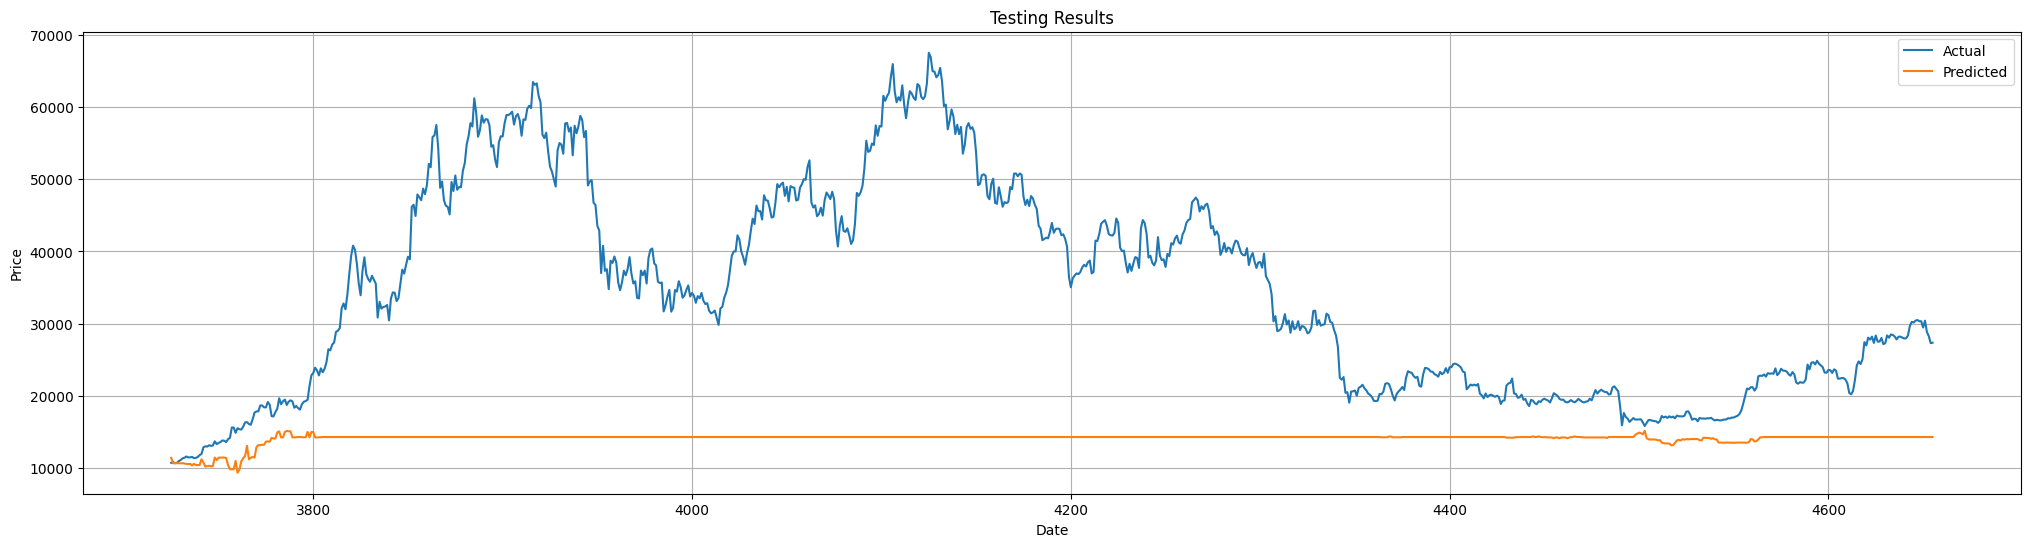

In [12]:
plot_result(xgb_result_test_df,'Testing Results')

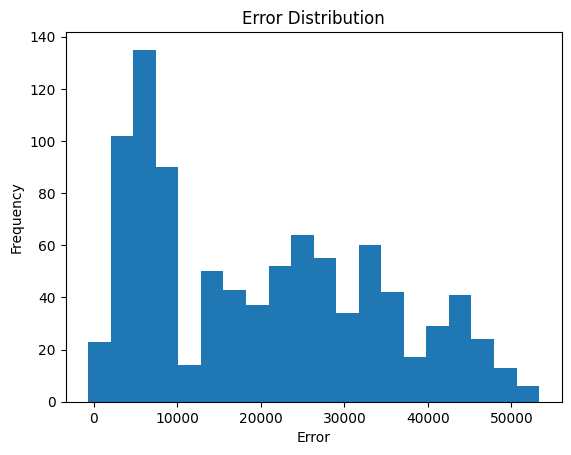

In [13]:
errors = y_test - ytest_pred_xgb
plt.hist(errors, bins=20)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

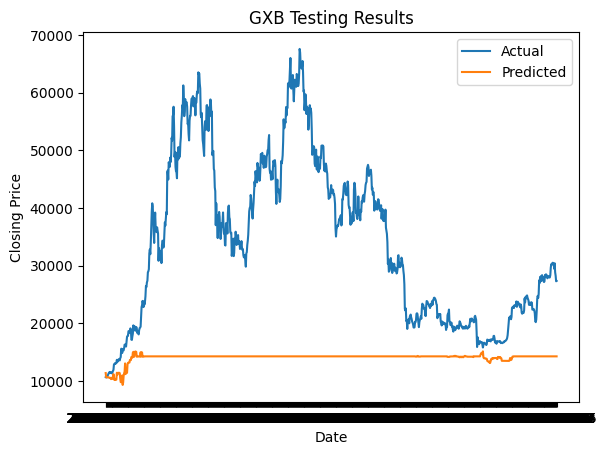

In [14]:
plt.plot(test_split['Date'], y_test, label='Actual')
plt.plot(test_split['Date'], ytest_pred_xgb, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('GXB Testing Results')
plt.legend()
plt.show()

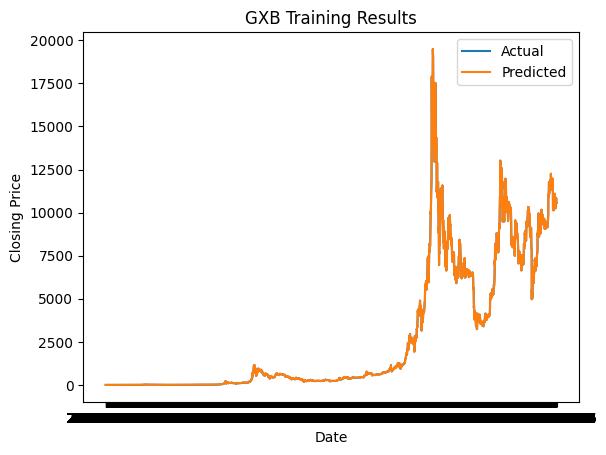

In [15]:
plt.plot(train_split['Date'], y_train, label='Actual')
plt.plot(train_split['Date'], ytrain_pred_xgb, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('GXB Training Results')
plt.legend()
plt.show()

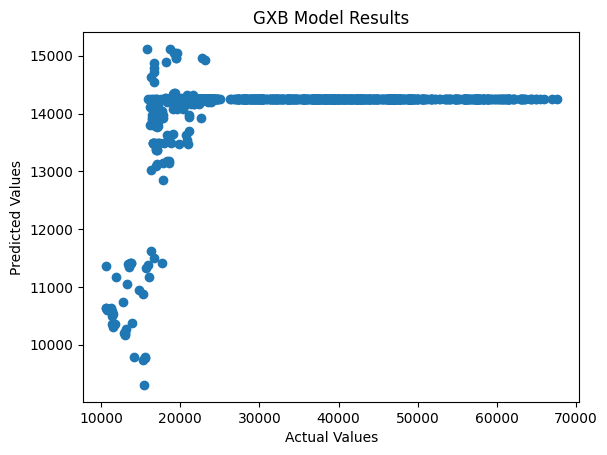

In [16]:
plt.scatter(y_test, ytest_pred_xgb)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('GXB Model Results')
plt.show()

In [17]:
# Further attempts to improve training with feature_importances_ attribute in XGB library
feature_importance = xgbm_reg.feature_importances_
feature_names = train_split.drop(['next_7th_day_closing_price','Date'],axis=1).columns
selected_features = feature_names[feature_importance > 0.05]

# Re-run the model with selected features
x_train_selected = train_split[selected_features].values
x_test_selected = test_split[selected_features].values

xgbm_reg = xgb.XGBRegressor(gamma=0.3, learning_rate=0.05, max_depth=15, n_estimators=1000, random_state=42, n_jobs=-1, objective='reg:squarederror')

# Train the model with early stopping and cross-validation
xgbm_reg.fit(x_train_selected, y_train, eval_set=[(x_test_selected, y_test)], early_stopping_rounds=300, verbose=False, eval_metric='rmse', 
             callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)])

# Make predictions on the training and test sets
ytrain_pred_xgb = xgbm_reg.predict(x_train_selected)
ytest_pred_xgb = xgbm_reg.predict(x_test_selected)



In [18]:
MAE_train, MSE_train, RMSE_train, R2_train = calculate_metrics(y_train,ytrain_pred_xgb)
MAE_test, MSE_test, RMSE_test, R2_test = calculate_metrics(y_test,ytest_pred_xgb)

print("Mean Absolute Error (MAE) for Training:", MAE_train)
print("Mean Squared Error (MSE) for Training:", MSE_train)
print("Root Mean Squared Error (RMSE) for Training:", RMSE_train)
print("R-squared score (R2) for Training:", R2_train)
print("********************************************")
print("Mean Absolute Error (MAE) for Testing:", MAE_test)
print("Mean Squared Error (MSE) for Testing:", MSE_test)
print("Root Mean Squared Error (RMSE) for Testing:", RMSE_test)
print("R-squared score (R2) for Testing:", R2_test)

Mean Absolute Error (MAE) for Training: 21.110478465041666
Mean Squared Error (MSE) for Training: 2633.9030795878407
Root Mean Squared Error (RMSE) for Training: 51.32156544365965
R-squared score (R2) for Training: 0.9998209970547299
********************************************
Mean Absolute Error (MAE) for Testing: 20203.4756740484
Mean Squared Error (MSE) for Testing: 613282670.3204317
Root Mean Squared Error (RMSE) for Testing: 24764.544621705278
R-squared score (R2) for Testing: -1.9898145493729777
